# **Data Preprocessing**





This notebook is dedicated to the **Data Processing Phase** of the project. Below are the key steps performed in this notebook:

1. **Loading and Inspecting the Dataset**: The raw hyperspectral dataset is loaded, visualized, and analyzed for its key properties.
2. **Noise Channel Detection and Removal**: Identifies and removes noisy channels based on visual inspection and statistical analysis to improve data quality.
3. **Data Normalization**: Applies standard normalization to ensure all spectral bands contribute equally to the variance.
4. **Dimensionality Reduction**: Performs PCA to reduce the dataset's dimensionality while retaining meaningful information.
5. **Tiling and Data Splitting**: Divides the dataset into smaller tiles and splits it into training, validation, and test sets to prevent data leakage.
6. **Data Augmentation**: Implements data augmentation techniques to address class imbalance and improve model generalization.

At the end of this notebook, the processed dataset is saved, making it ready for use in the **Train Models Notebook** and **Test Models Notebook**


## 1. Setup

### 1.1 Install and Import Libraries

In [ ]:
!pip install \
    scipy \
    numpy \
    pandas \
    scikit-learn \
    tensorflow \
    matplotlib \
    joblib \
    scikit-image \
    opencv-python-headless \
    xgboost


import os
import pickle
import random
import gc
from multiprocessing import Pool
import joblib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from google.colab import drive
from joblib import Parallel, delayed
from scipy.spatial.distance import euclidean
from skimage.transform import resize
from skimage.util import random_noise
from sklearn.decomposition import PCA
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.0 MB/s eta 0:00:00


### 1.2 Setting Seeds

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

### 1.3 Connect to Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### 1.4 Common Functions

In [ ]:
# Used in
# 2.Data Loading,
# 3.3 Remove Noise Channels
def flatten_data(images, labels):
    """
    Flatten the HSI images and labels.

    Parameters:
    - images (list): List of HSI images.
    - labels (list): List of HSI labels.

    Returns:
    - all_data (ndarray): Flattened HSI images.
    - all_labels (ndarray): Flattened HSI labels.
    """
    flattened_images = [image.reshape(-1, image.shape[-1]) for image in images]
    flattened_labels = [label.flatten() for label in labels]

    print("\nCombining flattened data...")
    all_data = np.vstack(flattened_images)
    all_labels = np.hstack(flattened_labels)

    print(f"\nFinal combined data shape: {all_data.shape}")
    print(f"Final combined labels shape: {all_labels.shape}")
    return all_data, all_labels

## 2. Data Loading

In [ ]:
def load_and_separate_hsi_images(folder_path):
    """
    Load hyperspectral images from .mat files in the specified folder and separate them into images and labels.
    Ignores metadata keys (starting with '__').

    Parameters:
    - folder_path (str): Path to the folder containing .mat files.

    Returns:
    - hsi_images_list (list): List of loaded hyperspectral images.
    - hsi_images_labels_list (list): List of corresponding labels.
    """
    hsi_images_list = []
    hsi_images_labels_list = []

    # Get and sort all .mat files in the specified folder
    file_names = sorted(
        [file for file in os.listdir(folder_path) if file.endswith('.mat')]
    )
    print(f"Found {len(file_names)} .mat files in the folder.")

    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)

        # Load the .mat file
        mat_data = scipy.io.loadmat(file_path)

        # Append all variables in the .mat file to the dataset, excluding metadata
        for key in mat_data:
            if not key.startswith('__'):
                if (len(hsi_images_list) + len(hsi_images_labels_list) + 1) % 2 == 1:
                    hsi_images_list.append(mat_data[key])
                    print(f"Loaded image/key '{key}' with shape {mat_data[key].shape} from {file_name}")
                else:
                    hsi_images_labels_list.append(mat_data[key])
                    print(f"Loaded label/key '{key}' with shape {mat_data[key].shape} from {file_name}")

    print(f"Total HSI images: {len(hsi_images_list)}")
    print(f"Total HSI labels: {len(hsi_images_labels_list)}")
    return hsi_images_list, hsi_images_labels_list


# Specify the folder containing the dataset
dataset_folder = '/content/drive/MyDrive/DataSets/HSI'

# Load and separate the HSI images and labels
hsi_images_list, hsi_images_labels_list = load_and_separate_hsi_images(dataset_folder)

# Flatten all images and labels
all_data, all_labels = flatten_data(hsi_images_list, hsi_images_labels_list)

print(f"All data shape: {all_data.shape}")
print(f"All labels shape: {all_labels.shape}")

Found 18 .mat files in the folder.
Loaded image/key 'img' with shape (1243, 684, 224) from GM01.mat
Loaded label/key 'map' with shape (1243, 684) from GM01.mat
Loaded image/key 'img' with shape (1786, 699, 224) from GM02.mat
Loaded label/key 'map' with shape (1786, 699) from GM02.mat
Loaded image/key 'img' with shape (1386, 690, 224) from GM03.mat
Loaded label/key 'map' with shape (1386, 690) from GM03.mat
Loaded image/key 'img' with shape (1466, 676, 224) from GM04.mat
Loaded label/key 'map' with shape (1466, 676) from GM04.mat
Loaded image/key 'img' with shape (2085, 682, 224) from GM05.mat
Loaded label/key 'map' with shape (2085, 682) from GM05.mat
Loaded image/key 'img' with shape (2088, 691, 224) from GM06.mat
Loaded label/key 'map' with shape (2088, 691) from GM06.mat
Loaded image/key 'img' with shape (1965, 492, 224) from GM07.mat
Loaded label/key 'map' with shape (1965, 492) from GM07.mat
Loaded image/key 'img' with shape (1532, 567, 224) from GM08.mat
Loaded label/key 'map' wi

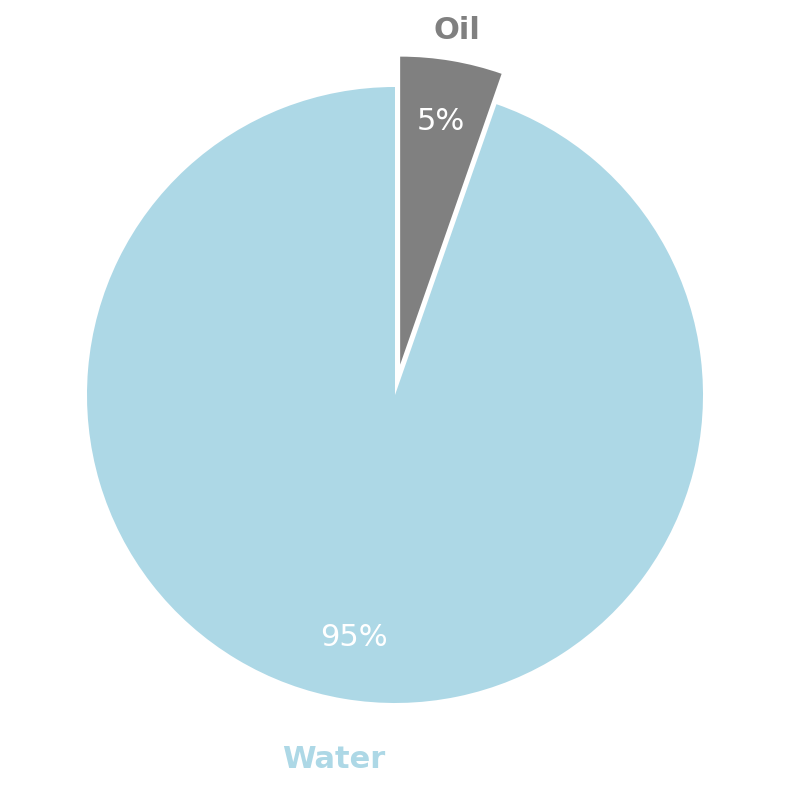

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace this with your actual `all_labels` array
# Example: all_labels = np.array([...])

# Count the occurrences of each label
unique_labels, counts = np.unique(all_labels, return_counts=True)

# Define labels and colors for the pie chart
categories = ['Water', 'Oil']
colors = ['lightblue', 'Gray']


# Create the pie chart
plt.figure(figsize=(10, 10))
explode = [0, 0.1]  # Highlight the 'Yes' category by separating it slightly
wedges, texts, autotexts = plt.pie(
    counts,
    explode=explode,  # Explode the 'Yes' section
    labels=None,  # External labels added manually
    autopct='%1.0f%%',  # Display percentages inside
    startangle=90,  # Start from the top
    colors=colors,  # Define slice colors
    textprops={'color': 'black'},
    pctdistance=0.8  # Position percentages closer to the center
)

# Add category names outside the pie chart
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2  # Find the middle angle of the wedge
    x = 1.2 * wedge.r * np.cos(np.radians(angle))  # Adjust x position for label
    y = 1.2 * wedge.r * np.sin(np.radians(angle))  # Adjust y position for label
    plt.text(
        x, y,
        categories[i],
        fontsize=22,  # Font size for category names
        fontweight='bold',
        color=colors[i],  # Use the same color as the pie slice
        ha='center',
        va='center'
    )

# Customize percentage labels inside the pie chart
for autotext in autotexts:
    autotext.set_fontsize(22)  # Increase font size for percentages
    autotext.set_color('white')  # Use white font color for better visibility


# Display the chart
plt.show()

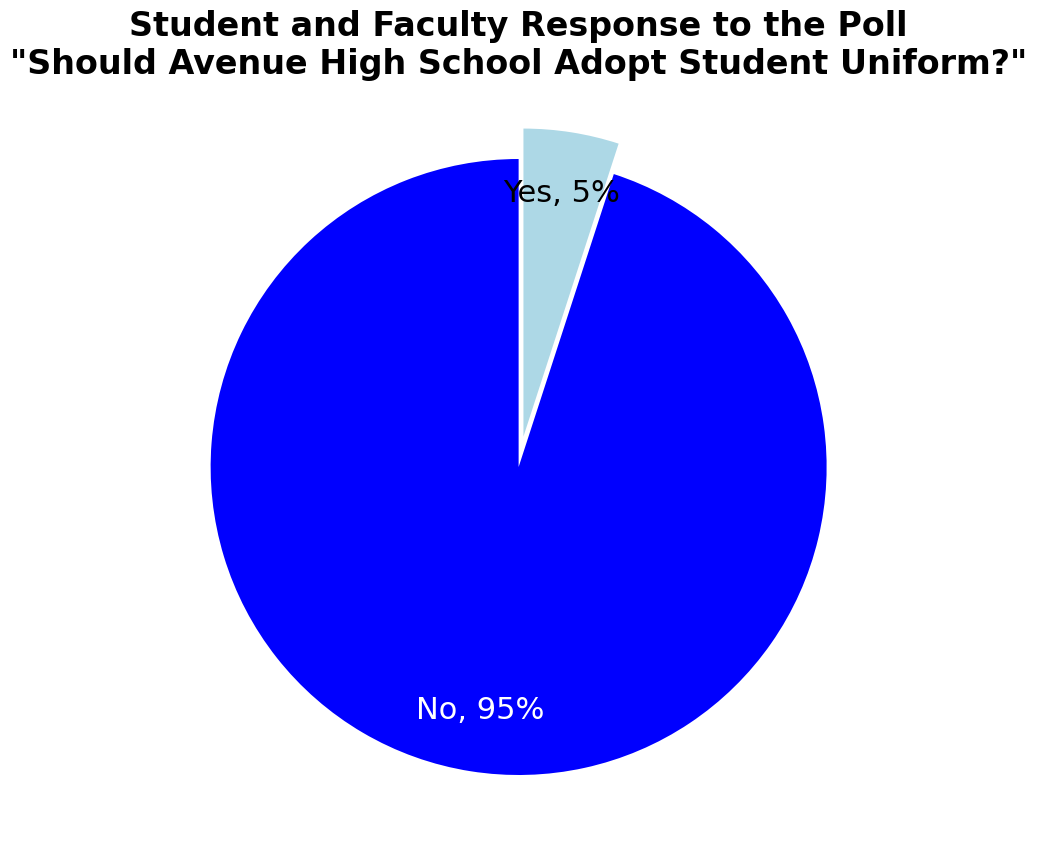

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace this with your actual `all_labels` array
# Example: all_labels = np.array([...])

# Dummy data for the example
categories = ['No', 'Yes']
counts = [95, 5]  # Example data: 90% No, 10% Yes
colors = ['blue', 'lightblue']  # Colors for the slices

# Create the pie chart
plt.figure(figsize=(10, 10))
explode = [0, 0.1]  # Highlight the 'Yes' category by slightly separating it
wedges, texts, autotexts = plt.pie(
    counts,
    explode=explode,  # Explode the 'Yes' section
    labels=None,  # Labels will be manually added inside the pie chart
    autopct='%1.0f%%',  # Display percentages as integers
    startangle=90,  # Start from the top
    colors=colors,  # Define slice colors
    textprops={'color': 'black'},
    pctdistance=0.8  # Adjust percentage position closer to the slice center
)

# Add category names and percentages inside the pie chart
for i, autotext in enumerate(autotexts):
    autotext.set_text(f"{categories[i]}, {autotext.get_text()}")
    if colors[i] == 'blue':
        autotext.set_color('white')  # White text for blue section
    autotext.set_fontsize(22)  # Larger font size for labels

# Add title
plt.title('Student and Faculty Response to the Poll\n"Should Avenue High School Adopt Student Uniform?"',
          fontsize=24, weight='bold', ha='center')

# Display the chart
plt.show()

## 3. Detect Noise Channels Using Visualization

In [ ]:
# Visual inspection for each channel
def visualize_hsi_channels_individually(hsi_images, num_channels):
    """
    Visualize each channel of each HSI image.
    """
    for image_idx, image in enumerate(hsi_images):
        print(f"Visualizing image {image_idx + 1} with shape {image.shape}")
        for channel in range(num_channels):
            plt.figure(figsize=(6, 6))
            plt.title(f"Image {image_idx + 1} - Channel {channel + 1}")
            plt.imshow(image[:, :, channel], cmap='gray')
            plt.colorbar()
            plt.show()

# Visualize channels without resizing
num_channels = 1   ## hsi_images_list[0].shape[-1]
visualize_hsi_channels_individually(hsi_images_list, num_channels)

Output hidden; open in https://colab.research.google.com to view.

### 3.1 Compare A Normal Channel with Noisy Channels

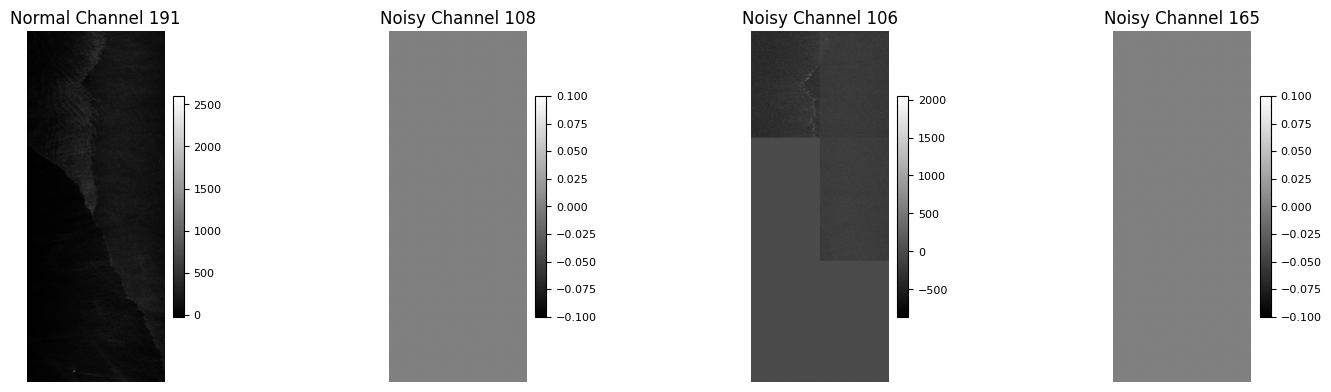

In [ ]:
import random
import matplotlib.pyplot as plt

# Define the list of noisy and non-noisy channels
noisy_channels = [106, 103, 107, 108, 109, 110, 111, 112, 113, 114, 152, 153, 154, 155, 156,
                  157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 221, 222, 223]

# Function to visualize specific channels
def visualize_selected_channels(image, noisy_channels, num_noisy=3):
    """
    Visualize one normal channel followed by a specified number of noisy channels for a given image.

    Parameters:
    - image: The HSI image to visualize.
    - noisy_channels: List of indices of noisy channels.
    - num_noisy: Number of noisy channels to randomly select.
    """
    # Identify non-noisy channels
    total_channels = image.shape[-1]
    all_channels = set(range(total_channels))
    non_noisy_channels = list(all_channels - set(noisy_channels))

    # Randomly select one normal channel
    selected_normal_channel = random.choice(non_noisy_channels)

    # Randomly select noisy channels
    selected_noisy_channels = random.sample(noisy_channels, num_noisy)

    # Combine the channels in the desired order (normal first)
    selected_channels = [selected_normal_channel] + selected_noisy_channels
    titles = [f"Normal Channel {selected_normal_channel}"] + [f"Noisy Channel {ch}" for ch in selected_noisy_channels]

    # Plot the selected channels horizontally with tighter spacing
    plt.figure(figsize=(16, 4))
    for i, channel in enumerate(selected_channels):
        ax = plt.subplot(1, len(selected_channels), i + 1)
        im = plt.imshow(image[:, :, channel], cmap='gray')
        ax.set_title(titles[i], fontsize=12, pad=5)  # Reduce padding for titles
        plt.axis('off')

        # Add a color bar with reduced spacing
        cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)  # Adjust fraction and pad for compact color bars
        cbar.ax.tick_params(labelsize=8)  # Adjust color bar tick size

    plt.tight_layout(pad=1.0, w_pad=1.0)  # Reduce overall subplot padding
    plt.show()


image_index = 1  # Python is zero-indexed
visualize_selected_channels(hsi_images_list[image_index], noisy_channels)

## 4. Remove Noise Channels

This piece of code removes the noisy channels from the loaded dataset, and updates the variables `hsi_images_list` and `all_data`.

In [ ]:
vis_noisy_channels = [
    106, 103, 107, 108, 109, 110, 111, 112, 113, 114, 152, 153, 154, 155, 156,
    157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 221, 222, 223
]

def remove_noise_chanels(hsi_dataset, noisy_channels):
    """
    Process the HSI dataset by removing noisy channels from images.

    Parameters:
    - hsi_dataset (list): List of HSI images and labels.
    - noisy_channels (list): List of indices of noisy channels to be removed.

    Returns:
    - cleaned_images (list): List of cleaned HSI images.
    - labels (list): List of HSI labels.
    """
    cleaned_images = []

    print("\nProcessing HSI dataset and removing noisy channels...")
    for i, hsi_image in enumerate(hsi_dataset):
        clean_image = np.delete(hsi_image, noisy_channels, axis=-1)
        cleaned_images.append(clean_image)
        print(f"Image {i + 1}: Cleaned shape {clean_image.shape} after removing {len(noisy_channels)} channels.")

    print(f"\nTotal cleaned HSI images: {len(cleaned_images)}")
    return cleaned_images



# Process and clean the HSI dataset
hsi_images_list = remove_noise_chanels(hsi_images_list, vis_noisy_channels)

# Flatten all images and labels
all_data, all_labels = flatten_data(hsi_images_list, hsi_images_labels_list)

print(f"All data shape: {all_data.shape}")
print(f"All labels shape: {all_labels.shape}")


Processing HSI dataset and removing noisy channels...
Image 1: Cleaned shape (1243, 684, 193) after removing 31 channels.
Image 2: Cleaned shape (1786, 699, 193) after removing 31 channels.
Image 3: Cleaned shape (1386, 690, 193) after removing 31 channels.
Image 4: Cleaned shape (1466, 676, 193) after removing 31 channels.
Image 5: Cleaned shape (2085, 682, 193) after removing 31 channels.
Image 6: Cleaned shape (2088, 691, 193) after removing 31 channels.
Image 7: Cleaned shape (1965, 492, 193) after removing 31 channels.
Image 8: Cleaned shape (1532, 567, 193) after removing 31 channels.
Image 9: Cleaned shape (1569, 517, 193) after removing 31 channels.
Image 10: Cleaned shape (1084, 680, 193) after removing 31 channels.
Image 11: Cleaned shape (1185, 682, 193) after removing 31 channels.
Image 12: Cleaned shape (842, 640, 193) after removing 31 channels.
Image 13: Cleaned shape (836, 572, 193) after removing 31 channels.
Image 14: Cleaned shape (1342, 527, 193) after removing 31 

In [ ]:
hsi_images_labels_list[0].shape

(1243, 684)

In [ ]:
vis_noisy_channels = [
    106, 103, 107, 108, 109, 110, 111, 112, 113, 114, 152, 153, 154, 155, 156,
    157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 221, 222, 223
]

def remove_noise_chanels(hsi_dataset, noisy_channels):
    """
    Process the HSI dataset by removing noisy channels from images.

    Parameters:
    - hsi_dataset (list): List of HSI images and labels.
    - noisy_channels (list): List of indices of noisy channels to be removed.

    Returns:
    - cleaned_images (list): List of cleaned HSI images.
    - labels (list): List of HSI labels.
    """
    cleaned_images = []

    print("\nProcessing HSI dataset and removing noisy channels...")
    for i, hsi_image in enumerate(hsi_dataset):
        clean_image = np.delete(hsi_image, noisy_channels, axis=-1)
        cleaned_images.append(clean_image)
        print(f"Image {i + 1}: Cleaned shape {clean_image.shape} after removing {len(noisy_channels)} channels.")

    print(f"\nTotal cleaned HSI images: {len(cleaned_images)}")
    return cleaned_images



# Process and clean the HSI dataset
hsi_images_list = remove_noise_chanels(hsi_images_list, vis_noisy_channels)

# Flatten all images and labels
all_data_filtered, all_labels = flatten_data(hsi_images_list, hsi_images_labels_list)

print(f"All data shape: {all_data.shape}")
print(f"All labels shape: {all_labels.shape}")


Processing HSI dataset and removing noisy channels...
Image 1: Cleaned shape (1243, 684, 193) after removing 31 channels.
Image 2: Cleaned shape (1786, 699, 193) after removing 31 channels.
Image 3: Cleaned shape (1386, 690, 193) after removing 31 channels.
Image 4: Cleaned shape (1466, 676, 193) after removing 31 channels.
Image 5: Cleaned shape (2085, 682, 193) after removing 31 channels.
Image 6: Cleaned shape (2088, 691, 193) after removing 31 channels.
Image 7: Cleaned shape (1965, 492, 193) after removing 31 channels.
Image 8: Cleaned shape (1532, 567, 193) after removing 31 channels.
Image 9: Cleaned shape (1569, 517, 193) after removing 31 channels.
Image 10: Cleaned shape (1084, 680, 193) after removing 31 channels.
Image 11: Cleaned shape (1185, 682, 193) after removing 31 channels.
Image 12: Cleaned shape (842, 640, 193) after removing 31 channels.
Image 13: Cleaned shape (836, 572, 193) after removing 31 channels.
Image 14: Cleaned shape (1342, 527, 193) after removing 31 

## 5. Tile Data and Split To Train, Validation, Test Sets

In [ ]:

def split_into_tiles(image, label, mask, tile_size):
    """
    Splits the pre-padded image, label, and mask into tiles.

    Parameters:
    - image (np.ndarray): Padded input image.
    - label (np.ndarray): Padded corresponding label.
    - mask (np.ndarray): Binary mask indicating real pixels in the padded image.
    - tile_size (tuple): (tile_height, tile_width) specifying the size of the tiles.

    Returns:
    - tiles (np.ndarray): List of image tiles.
    - label_tiles (np.ndarray): List of label tiles.
    - mask_tiles (np.ndarray): List of mask tiles.
    """
    h, w, _ = image.shape
    tiles, label_tiles, mask_tiles = [], [], []

    for i in range(0, h, tile_size[0]):
        for j in range(0, w, tile_size[1]):
            img_tile = image[i:i + tile_size[0], j:j + tile_size[1], :]
            lbl_tile = label[i:i + tile_size[0], j:j + tile_size[1]]
            msk_tile = mask[i:i + tile_size[0], j:j + tile_size[1]]

            if img_tile.shape[:2] == tile_size:
                tiles.append(img_tile)
                label_tiles.append(np.expand_dims(lbl_tile, axis=-1))  # Add channel dimension
                mask_tiles.append(msk_tile)

    print(f"Split image into {len(tiles)} tiles.")
    return np.array(tiles), np.array(label_tiles), np.array(mask_tiles)


def custom_padding(image, label, tile_size):
    """
    Custom padding that uses the average value of water pixels (label=0) for padding.

    Parameters:
    - image (np.ndarray): Input image (H, W, C).
    - label (np.ndarray): Corresponding label (H, W).
    - tile_size (tuple): (tile_height, tile_width).

    Returns:
    - padded_image (np.ndarray): Image padded with average water pixel values.
    - padded_label (np.ndarray): Label padded with zeros.
    - mask (np.ndarray): Binary mask indicating original, unpadded regions.
    """
    h, w, c = image.shape
    pad_h = (tile_size[0] - h % tile_size[0]) % tile_size[0]
    pad_w = (tile_size[1] - w % tile_size[1]) % tile_size[1]

    # Calculate average water pixel value across channels
    water_mask = (label == 0)
    water_mask_expanded = np.repeat(water_mask[:, :, np.newaxis], c, axis=2)
    avg_water_value = (
        image[water_mask_expanded].reshape(-1, c).mean(axis=0)
        if np.any(water_mask)
        else np.zeros(c)
    )

    # Pad each channel
    padded_channels = []
    for channel in range(c):
        padded_channel = np.pad(
            image[:, :, channel],
            ((0, pad_h), (0, pad_w)),
            mode="constant",
            constant_values=avg_water_value[channel],
        )
        padded_channels.append(padded_channel)

    padded_image = np.stack(padded_channels, axis=-1)

    # Pad label
    padded_label = np.pad(label, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0)

    # Create mask
    mask = np.ones((h, w), dtype=bool)
    mask = np.pad(mask, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=False)

    print(f"Padded image shape: {padded_image.shape}")
    print(f"Padded label shape: {padded_label.shape}")

    return padded_image, padded_label, mask


def preprocess_and_split(images, labels, tile_size, train_ratio=0.6, test_ratio=0.2, val_ratio=0.2):
    """
    Preprocess images and labels into tiles, and split them into train, test, and validation sets.

    Parameters:
    - images (list): List of input images as NumPy arrays.
    - labels (list): List of corresponding labels as NumPy arrays.
    - tile_size (tuple): (tile_height, tile_width) specifying the size of the tiles.
    - train_ratio (float): Ratio of tiles for the training set.
    - test_ratio (float): Ratio of tiles for the testing set.
    - val_ratio (float): Ratio of tiles for the validation set.

    Returns:
    - train_images, train_labels: Tiles and labels for training.
    - val_images, val_labels: Tiles and labels for validation.
    - test_images, test_labels, test_masks: Tiles, labels, and masks for testing.
    """
    assert train_ratio + test_ratio + val_ratio == 1.0, "Ratios must sum to 1."

    train_images, train_labels = [], []
    test_images, test_labels, test_masks = [], [], []
    val_images, val_labels = [], []

    for idx in range(len(images)):
        # Apply custom padding
        image_padded, label_padded, mask = custom_padding(images[idx], labels[idx], tile_size)

        # Split into tiles
        tiles, lbl_tiles, mask_tiles = split_into_tiles(image_padded, label_padded, mask, tile_size)

        # Shuffle tiles
        combined = list(zip(tiles, lbl_tiles))
        np.random.shuffle(combined)
        tiles, lbl_tiles = zip(*combined) if combined else ([], [])

        # Split into train, test, and validation sets
        total_tiles = len(tiles)
        train_count = int(total_tiles * train_ratio)
        test_count = int(total_tiles * test_ratio)

        train_images.extend(tiles[:train_count])
        train_labels.extend(lbl_tiles[:train_count])

        val_images.extend(tiles[train_count:train_count + test_count])
        val_labels.extend(lbl_tiles[train_count:train_count + test_count])

        test_images.extend(tiles[train_count + test_count:])
        test_labels.extend(lbl_tiles[train_count + test_count:])
        test_masks.extend(mask_tiles[train_count + test_count:])

    # Normalize images and convert labels
    train_images = np.array(train_images) / 255.0
    train_labels = np.array(train_labels).astype("float32")

    test_images = np.array(test_images) / 255.0
    test_labels = np.array(test_labels).astype("float32")
    test_masks = np.array(test_masks)

    val_images = np.array(val_images) / 255.0
    val_labels = np.array(val_labels).astype("float32")

    print(f"\nTrain images: {train_images.shape}, Train labels: {train_labels.shape}")
    print(f"Validation images: {val_images.shape}, Validation labels: {val_labels.shape}")
    print(f"Test images: {test_images.shape}, Test labels: {test_labels.shape}, Test masks: {test_masks.shape}")

    return train_images, train_labels, val_images, val_labels, test_images, test_labels, test_masks


# Example data
images = hsi_images_list  # Replace with your actual dataset
labels = hsi_images_labels_list  # Replace with your actual labels
tile_size = (64, 64)

# Preprocess and split the data
train_images, train_labels, val_images, val_labels, test_images, test_labels, test_masks = preprocess_and_split(
    images, labels, tile_size
)

Padded image shape: (1280, 704, 193)
Padded label shape: (1280, 704)
Split image into 220 tiles.
Padded image shape: (1792, 704, 193)
Padded label shape: (1792, 704)
Split image into 308 tiles.
Padded image shape: (1408, 704, 193)
Padded label shape: (1408, 704)
Split image into 242 tiles.
Padded image shape: (1472, 704, 193)
Padded label shape: (1472, 704)
Split image into 253 tiles.
Padded image shape: (2112, 704, 193)
Padded label shape: (2112, 704)
Split image into 363 tiles.
Padded image shape: (2112, 704, 193)
Padded label shape: (2112, 704)
Split image into 363 tiles.
Padded image shape: (1984, 512, 193)
Padded label shape: (1984, 512)
Split image into 248 tiles.
Padded image shape: (1536, 576, 193)
Padded label shape: (1536, 576)
Split image into 216 tiles.
Padded image shape: (1600, 576, 193)
Padded label shape: (1600, 576)
Split image into 225 tiles.
Padded image shape: (1088, 704, 193)
Padded label shape: (1088, 704)
Split image into 187 tiles.
Padded image shape: (1216, 704

## 6. Data Augmentation

In [ ]:
def rotate_image(image, label, angle):
    """
    Rotate the image and label by a given angle.

    Parameters:
    - image: NumPy array of the image.
    - label: NumPy array of the label.
    - angle: Rotation angle in degrees.

    Returns:
    - rotated_image: Rotated image.
    - rotated_label: Rotated label.
    """
    print(f"Rotating image by {angle} degrees.")
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    rotated_label = cv2.warpAffine(label, rotation_matrix, (label.shape[1], label.shape[0]), flags=cv2.INTER_NEAREST)
    return rotated_image, rotated_label


def flip_image(image, label):
    """
    Flip the image and label randomly either horizontally or vertically.

    Parameters:
    - image: NumPy array of the image.
    - label: NumPy array of the label.

    Returns:
    - flipped_image: Flipped image.
    - flipped_label: Flipped label.
    """
    flip_type = "vertical" if random.choice([True, False]) else "horizontal"
    print(f"Flipping image {flip_type}.")
    flip_code = 0 if flip_type == "vertical" else 1
    flipped_image = cv2.flip(image, flip_code)
    flipped_label = cv2.flip(label, flip_code)
    return flipped_image, flipped_label


def add_gaussian_noise(image, mean=0, var=0.01):
    """
    Add Gaussian noise to the image (labels remain unaffected).

    Parameters:
    - image: NumPy array of the image.
    - mean: Mean of the Gaussian noise.
    - var: Variance of the Gaussian noise.

    Returns:
    - noisy_image: Image with Gaussian noise added.
    """
    print("Adding Gaussian noise to the image.")
    noisy_image = random_noise(image, mode='gaussian', mean=mean, var=var)
    noisy_image = np.array(255 * noisy_image, dtype=np.uint8)  # Convert back to 0-255 range
    return noisy_image


def augment_images(image, label):
    """
    Augment the image and label with various augmentations like rotations and flipping.

    Parameters:
    - image: NumPy array of the image.
    - label: NumPy array of the corresponding label.

    Returns:
    - augmented_images: List of augmented images.
    - augmented_labels: List of corresponding augmented labels.
    """
    print("Applying augmentations to the image and label.")
    augmented_images = []
    augmented_labels = []

    # Apply rotations
    for angle in [90, 180, 270]:
        rotated_image, rotated_label = rotate_image(image, label, angle)
        augmented_images.append(rotated_image)
        augmented_labels.append(rotated_label)

    # Apply flipping
    flipped_image, flipped_label = flip_image(image, label)
    augmented_images.append(flipped_image)
    augmented_labels.append(flipped_label)

    # Optionally add Gaussian noise
    noisy_image = add_gaussian_noise(image)
    augmented_images.append(noisy_image)
    augmented_labels.append(label)  # Label remains unchanged for noise augmentation

    print(f"Total augmentations for this image: {len(augmented_images)}")
    return augmented_images, augmented_labels


def augment_dataset(images, labels):
    """
    Apply augmentations to a dataset of images and labels.

    Parameters:
    - images: List of NumPy arrays representing the images.
    - labels: List of NumPy arrays representing the corresponding labels.

    Returns:
    - augmented_images: List of augmented images.
    - augmented_labels: List of augmented labels.
    """
    print("Starting dataset augmentation.")
    augmented_images = []
    augmented_labels = []

    for idx, (image, label) in enumerate(zip(images, labels)):
        print(f"Processing image {idx + 1}/{len(images)} with shape {image.shape}.")
        if np.all(label == 0): #no only-water tile is augmented
            print(f"Skipping augmentation for image {idx + 1} (only water).")
            augmented_images.append(image)
            augmented_labels.append(label)
            continue  # Skip augmentation for this tile

        # Add original image and label
        augmented_images.append(image)
        augmented_labels.append(label)

        # Apply augmentations
        augmented_image_set, augmented_label_set = augment_images(image, label)
        augmented_images.extend(augmented_image_set)
        augmented_labels.extend(augmented_label_set)

    print(f"Completed dataset augmentation. Total augmented images: {len(augmented_images)}")
    return augmented_images, augmented_labels


In [ ]:
gc.collect()

print("Starting training data augmentation.")
augmented_train_images, augmented_train_labels = augment_dataset(train_images, train_labels)

# Ensure labels have the correct dimensions
converted_train_labels = []
for idx, lbl in enumerate(augmented_train_labels):
    if lbl.ndim == 2:  # If the label is (H, W), add a channel dimension
        lbl = np.expand_dims(lbl, axis=-1)
    elif lbl.shape[-1] != 1:  # Ensure the last dimension is 1
        raise ValueError(f"Label {idx + 1} has unexpected shape: {lbl.shape}")
    converted_train_labels.append(lbl)

train_images = np.array(augmented_train_images)
train_labels = np.array(converted_train_labels)

print(f"Final augmented training dataset shape: {train_images.shape}")
print(f"Final augmented labels dataset shape: {train_labels.shape}")
gc.collect()

Streaming output truncated to the last 5000 lines.
Rotating image by 180 degrees.
Rotating image by 270 degrees.
Flipping image horizontal.
Adding Gaussian noise to the image.
Total augmentations for this image: 5
Processing image 511/1134 with shape (64, 64, 193).
Applying augmentations to the image and label.
Rotating image by 90 degrees.
Rotating image by 180 degrees.
Rotating image by 270 degrees.
Flipping image horizontal.
Adding Gaussian noise to the image.
Total augmentations for this image: 5
Processing image 512/1134 with shape (64, 64, 193).
Applying augmentations to the image and label.
Rotating image by 90 degrees.
Rotating image by 180 degrees.
Rotating image by 270 degrees.
Flipping image horizontal.
Adding Gaussian noise to the image.
Total augmentations for this image: 5
Processing image 513/1134 with shape (64, 64, 193).
Applying augmentations to the image and label.
Rotating image by 90 degrees.
Rotating image by 180 degrees.
Rotating image by 270 degrees.
Flipping im

0

## 7. Flatten Augmented data for PCA

In [ ]:

def flatten_dataset(images, labels):
    """
    Flatten the images and labels into a 2D array for the images and a 1D array for the labels.

    Parameters:
    - images: List of NumPy arrays representing the images (H, W, C).
    - labels: List of NumPy arrays representing the corresponding labels (H, W, 1).

    Returns:
    - flattened_images: 2D array of flattened images (num_pixels, num_features).
    - flattened_labels: 1D array of flattened labels (num_pixels).
    """
    flattened_images = []
    flattened_labels = []

    for idx, (image, label) in enumerate(zip(images, labels)):
        print(f"Flattening image {idx + 1}/{len(images)} with shape {image.shape}.")
        flattened_images.append(image.reshape(-1, image.shape[-1]))
        flattened_labels.append(label.flatten())

    flattened_images = np.vstack(flattened_images)
    flattened_labels = np.hstack(flattened_labels)

    print(f"Flattened images shape: {flattened_images.shape}")
    print(f"Flattened labels shape: {flattened_labels.shape}")
    return flattened_images, flattened_labels


# Flatten training data
print("\nFlattening training data...")
train_data_flattened, train_labels_flattened = flatten_dataset(train_images, train_labels)

# Flatten validation data
print("\nFlattening validation data...")
val_data_flattened, val_labels_flattened = flatten_dataset(val_images, val_labels)

# Flatten test data
print("\nFlattening test data...")
test_data_flattened, test_labels_flattened = flatten_dataset(test_images, test_labels)

# Final results
print("\nFinal Flattened Data Shapes:")
print(f"Train Data: {train_data_flattened.shape}, Train Labels: {train_labels_flattened.shape}")
print(f"Validation Data: {val_data_flattened.shape}, Validation Labels: {val_labels_flattened.shape}")
print(f"Test Data: {test_data_flattened.shape}, Test Labels: {test_labels_flattened.shape}")

Streaming output truncated to the last 5000 lines.
Flattening image 3359/6804 with shape (64, 64, 193).
Flattening image 3360/6804 with shape (64, 64, 193).
Flattening image 3361/6804 with shape (64, 64, 193).
Flattening image 3362/6804 with shape (64, 64, 193).
Flattening image 3363/6804 with shape (64, 64, 193).
Flattening image 3364/6804 with shape (64, 64, 193).
Flattening image 3365/6804 with shape (64, 64, 193).
Flattening image 3366/6804 with shape (64, 64, 193).
Flattening image 3367/6804 with shape (64, 64, 193).
Flattening image 3368/6804 with shape (64, 64, 193).
Flattening image 3369/6804 with shape (64, 64, 193).
Flattening image 3370/6804 with shape (64, 64, 193).
Flattening image 3371/6804 with shape (64, 64, 193).
Flattening image 3372/6804 with shape (64, 64, 193).
Flattening image 3373/6804 with shape (64, 64, 193).
Flattening image 3374/6804 with shape (64, 64, 193).
Flattening image 3375/6804 with shape (64, 64, 193).
Flattening image 3376/6804 with shape (64, 64, 1

In [ ]:

gc.collect()

0

## 8. Normalization: Channel Ranges Value


Feature Statistics:
     Feature Index    Min    Max        Mean     Std Dev       Variance
0                0  -1736    884   27.458890  417.290602  174131.446378
1                1  -2351   3495   58.454955  504.095531  254112.304444
2                2  -2354   3499  424.641037  300.503027   90302.069384
3                3    -77   3034  559.180598  261.296415   68275.816654
4                4      0   4170  728.762951  414.112021  171488.766066
..             ...    ...    ...         ...         ...            ...
219            219 -26781  32202   -5.822035   24.612059     605.753473
220            220 -24340  27418   -9.196870   25.274151     638.782725
221            221 -10604  24237  -12.860256   33.236749    1104.681506
222            222   -931   1046   -6.672494   25.970198     674.451176
223            223  -1105   1234   -9.159716   30.360321     921.749090

[224 rows x 6 columns]


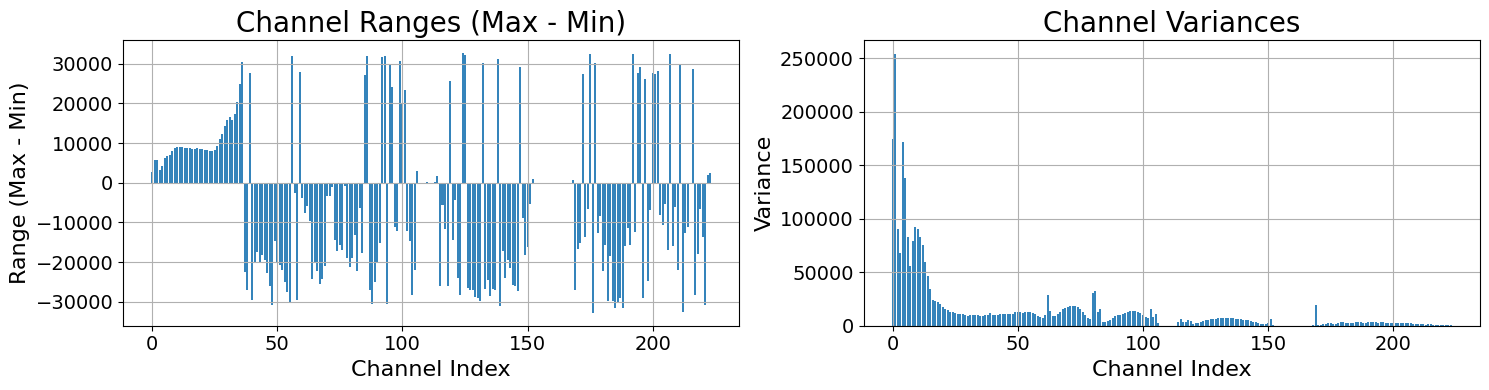

In [ ]:
def analyze_feature_scaling(data):
    """
    Analyze the scale of features in the dataset to determine if normalization is necessary.

    Parameters:
    - data: 2D array (n_samples, n_features)

    Returns:
    - A summary table with statistics for each feature.
    - Visualization of feature ranges and variances using default Matplotlib light blue color and large font sizes.
    """
    # Calculate min, max, mean, standard deviation, and variance for each feature
    feature_stats = {
        "Feature Index": np.arange(data.shape[1]),
        "Min": np.min(data, axis=0),
        "Max": np.max(data, axis=0),
        "Mean": np.mean(data, axis=0),
        "Std Dev": np.std(data, axis=0),
        "Variance": np.var(data, axis=0)
    }

    # Create a DataFrame for better visualization
    stats_df = pd.DataFrame(feature_stats)

    # Print the summary table
    print("\nFeature Statistics:")
    print(stats_df.head(len(stats_df)))  # Display all features

    # Plot feature ranges and variances
    plt.figure(figsize=(15, 4))  # Larger figure size for clarity

    # Plot ranges (Min-Max)
    plt.subplot(1, 2, 1)
    plt.bar(stats_df["Feature Index"], stats_df["Max"] - stats_df["Min"], alpha=0.9)
    plt.title("Channel Ranges (Max - Min)", fontsize=20)
    plt.xlabel("Channel Index", fontsize=16)
    plt.ylabel("Range (Max - Min)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)

    # Plot variances
    plt.subplot(1, 2, 2)
    plt.bar(stats_df["Feature Index"], stats_df["Variance"], alpha=0.9)
    plt.title("Channel Variances", fontsize=20)
    plt.xlabel("Channel Index", fontsize=16)
    plt.ylabel("Variance", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)

    # Adjust layout for readability
    plt.tight_layout()
    plt.show()

    return stats_df

# Analyze the scaling of features in the dataset
feature_summary = analyze_feature_scaling(all_data)

## 9. PCA: Plot Variance Explanation vs. Number of Components

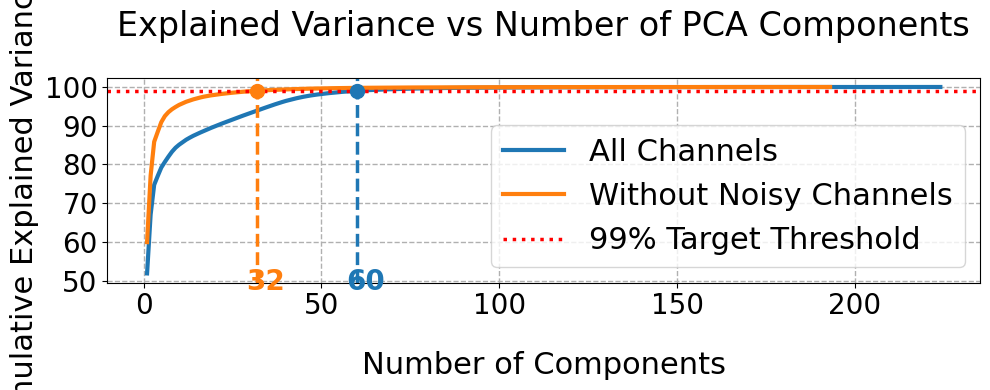


Variance Information:
All Channels: 60 components needed for 99% variance.
Without Noisy Channels: 32 components needed for 99% variance.

Variance Information:
All Channels: 60 components needed for 99% variance.
Without Noisy Channels: 32 components needed for 99% variance.


0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gc

gc.collect()
scaler = StandardScaler()

# Scale the entire dataset
all_data_scaled = scaler.fit_transform(all_data)

# Perform PCA on the full dataset (all channels)
n_components_all = min(all_data.shape)
pca_all = PCA(n_components=n_components_all)
pca_all.fit(all_data_scaled)
cumulative_variance_all = np.cumsum(pca_all.explained_variance_ratio_)
n_components_99_all = np.argmax(cumulative_variance_all >= 0.99) + 1

# Scale the dataset without noisy channels
cleaned_data_scaled = scaler.fit_transform(all_data_filtered)  # Assuming `all_data_filtered` is your dataset without noisy channels
n_components_cleaned = min(all_data_filtered.shape)
pca_cleaned = PCA(n_components=n_components_cleaned)
pca_cleaned.fit(cleaned_data_scaled)
cumulative_variance_cleaned = np.cumsum(pca_cleaned.explained_variance_ratio_)
n_components_99_cleaned = np.argmax(cumulative_variance_cleaned >= 0.99) + 1


# Plot cumulative variance for both cases with enhanced readability and x-axis labels for components
plt.figure(figsize=(10, 6))

# Plot for all channels
plt.plot(range(1, len(cumulative_variance_all) + 1),
         cumulative_variance_all * 100,
         color='#1f77b4', linewidth=3, label='All Channels')
plt.axvline(x=n_components_99_all, color='#1f77b4', linestyle='--', linewidth=2.5)
plt.scatter([n_components_99_all], [cumulative_variance_all[n_components_99_all - 1] * 100],
            color='#1f77b4', s=100, edgecolor='#1f77b4', zorder=5)  # Match edgecolor to line color
plt.text(n_components_99_all - 3, 47.5, str(n_components_99_all), color='#1f77b4', fontsize=20, fontweight='bold')

# Plot for cleaned channels
plt.plot(range(1, len(cumulative_variance_cleaned) + 1),
         cumulative_variance_cleaned * 100,
         color='#ff7f0e', linewidth=3, label='Without Noisy Channels')
plt.axvline(x=n_components_99_cleaned, color='#ff7f0e', linestyle='--', linewidth=2.5)
plt.scatter([n_components_99_cleaned], [cumulative_variance_cleaned[n_components_99_cleaned - 1] * 100],
            color='#ff7f0e', s=100, edgecolor='#ff7f0e', zorder=5)  # Match edgecolor to line color
plt.text(n_components_99_cleaned - 3, 47.5, str(n_components_99_cleaned), color='#ff7f0e', fontsize=20, fontweight='bold')

# Horizontal line for 99% variance
plt.axhline(y=99, color='red', linestyle=':', linewidth=2.5, label='99% Target Threshold')

# Set larger fonts for labels and title
plt.xlabel('Number of Components', fontsize=22,  labelpad=22)
plt.ylabel('Cumulative Explained Variance (%)', fontsize=22)
plt.title('Explained Variance vs Number of PCA Components', fontsize=24, pad=30)

# Customize ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Customize legend
plt.legend(fontsize=22, loc='lower right', frameon=True)

# Enable grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=1)

# Adjust layout for clarity
plt.tight_layout()

# Display the plot
plt.show()

# Print detailed variance information for both cases
print("\nVariance Information:")
print(f"All Channels: {n_components_99_all} components needed for 99% variance.")
print(f"Without Noisy Channels: {n_components_99_cleaned} components needed for 99% variance.")

gc.collect()

# Display the plot
plt.show()

# Print detailed variance information for both cases
print("\nVariance Information:")
print(f"All Channels: {n_components_99_all} components needed for 99% variance.")
print(f"Without Noisy Channels: {n_components_99_cleaned} components needed for 99% variance.")

gc.collect()

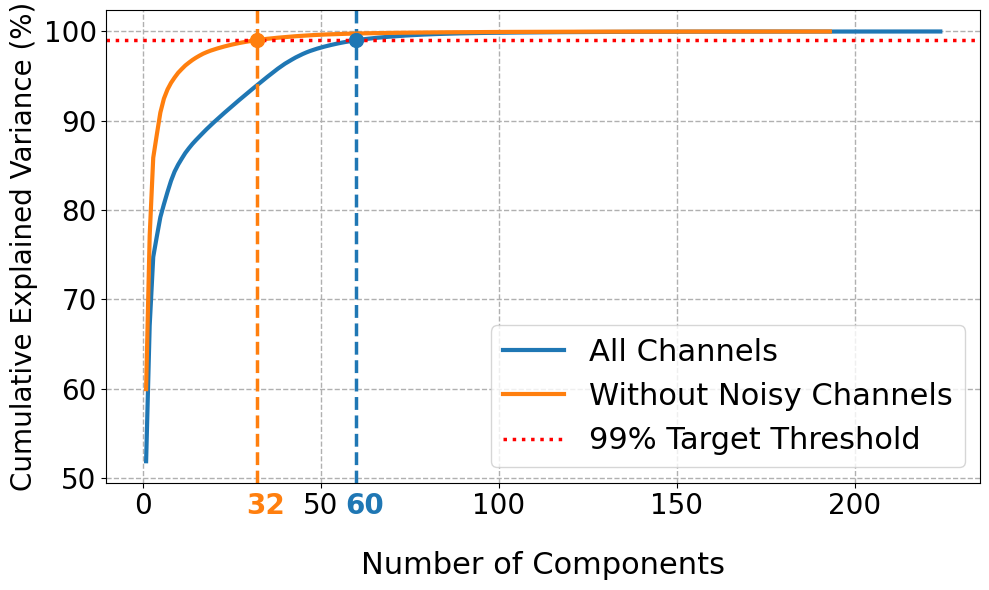


Variance Information:
All Channels: 60 components needed for 99% variance.
Without Noisy Channels: 32 components needed for 99% variance.

Variance Information:
All Channels: 60 components needed for 99% variance.
Without Noisy Channels: 32 components needed for 99% variance.


0

In [ ]:
# Plot cumulative variance for both cases with enhanced readability and x-axis labels for components
plt.figure(figsize=(10, 6))

# Plot for all channels
plt.plot(range(1, len(cumulative_variance_all) + 1),
         cumulative_variance_all * 100,
         color='#1f77b4', linewidth=3, label='All Channels')
plt.axvline(x=n_components_99_all, color='#1f77b4', linestyle='--', linewidth=2.5)
plt.scatter([n_components_99_all], [cumulative_variance_all[n_components_99_all - 1] * 100],
            color='#1f77b4', s=100, edgecolor='#1f77b4', zorder=5)  # Match edgecolor to line color
plt.text(n_components_99_all - 3, 46, str(n_components_99_all), color='#1f77b4', fontsize=20, fontweight='bold')

# Plot for cleaned channels
plt.plot(range(1, len(cumulative_variance_cleaned) + 1),
         cumulative_variance_cleaned * 100,
         color='#ff7f0e', linewidth=3, label='Without Noisy Channels')
plt.axvline(x=n_components_99_cleaned, color='#ff7f0e', linestyle='--', linewidth=2.5)
plt.scatter([n_components_99_cleaned], [cumulative_variance_cleaned[n_components_99_cleaned - 1] * 100],
            color='#ff7f0e', s=100, edgecolor='#ff7f0e', zorder=5)  # Match edgecolor to line color
plt.text(n_components_99_cleaned - 3, 46, str(n_components_99_cleaned), color='#ff7f0e', fontsize=20, fontweight='bold')

# Horizontal line for 99% variance
plt.axhline(y=99, color='red', linestyle=':', linewidth=2.5, label='99% Target Threshold')

# Set larger fonts for labels and title
plt.xlabel('Number of Components', fontsize=22,  labelpad=22)
plt.ylabel('Cumulative Explained Variance (%)', fontsize=20)

# Customize ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Customize legend
plt.legend(fontsize=22, loc='lower right', frameon=True)

# Enable grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=1)

# Adjust layout for clarity
plt.tight_layout()

# Display the plot
plt.show()

# Print detailed variance information for both cases
print("\nVariance Information:")
print(f"All Channels: {n_components_99_all} components needed for 99% variance.")
print(f"Without Noisy Channels: {n_components_99_cleaned} components needed for 99% variance.")

gc.collect()

# Display the plot
plt.show()

# Print detailed variance information for both cases
print("\nVariance Information:")
print(f"All Channels: {n_components_99_all} components needed for 99% variance.")
print(f"Without Noisy Channels: {n_components_99_cleaned} components needed for 99% variance.")

gc.collect()

## 10. Apply PCA

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on the training data
scaler.fit(train_data_flattened)

# Transform train, validation, and test sets
train_data_normalized = scaler.transform(train_data_flattened)
val_data_normalized = scaler.transform(val_data_flattened)
test_data_normalized = scaler.transform(test_data_flattened)

In [ ]:
n_components = 32
# Apply PCA to reduce to n features
pca = PCA(n_components)
reduced_Train_data_flat = pca.fit_transform(train_data_normalized)
reduced_Val_data_flat = pca.transform(val_data_normalized)
reduced_Test_data_flat = pca.transform(test_data_normalized)

## 11. Save the Processed Dataset

In [ ]:
gc.collect()
# Define the number of PCA components dynamically
base_save_path = "/content/drive/MyDrive/DataSets/HSI-Augmented-Splitted"

# Function to reshape reduced data back to original image sizes
def reshape_reduced_data(reduced_data_flat, original_images, n_components):
    """
    Reshape the flattened reduced data back to the original image sizes.

    Parameters:
    - reduced_data_flat (np.ndarray): Flattened reduced data of shape (num_pixels, n_components).
    - original_images (list): List of original images for size reference.
    - n_components (int): Number of PCA components.

    Returns:
    - reshaped_data (list): List of reshaped images with reduced dimensions.
    """
    reshaped_data = []
    start_idx = 0

    for idx, image in enumerate(original_images):
        original_shape = image.shape
        num_pixels = original_shape[0] * original_shape[1]
        reshaped_image = reduced_data_flat[start_idx:start_idx + num_pixels].reshape(
            original_shape[0], original_shape[1], n_components
        )
        reshaped_data.append(reshaped_image)
        start_idx += num_pixels

    return reshaped_data


# Reshape reduced train, validation, and test data
print("\nReshaping training data...")
reduced_Train_data = reshape_reduced_data(reduced_Train_data_flat, train_images, n_components)

print("\nReshaping validation data...")
reduced_Val_data = reshape_reduced_data(reduced_Val_data_flat, val_images, n_components)

print("\nReshaping test data...")
reduced_Test_data = reshape_reduced_data(reduced_Test_data_flat, test_images, n_components)


# Function to save reduced data and labels to .npz format
def save_to_npz(data, save_path, label="data"):
    """
    Save data to a compressed .npz format.

    Parameters:
    - data (list): List of data to save (images or labels).
    - save_path (str): Path to save the .npz file.
    - label (str): Base label name for each item.
    """
    save_dict = {f"{label}_{i}": item for i, item in enumerate(data)}
    np.savez_compressed(save_path, **save_dict)
    print(f"Saved {len(data)} items to {save_path}")


# Generate save paths dynamically
save_path_Tr_Data = f"{base_save_path}/TrainTiles_{n_components}PCA_normalized.npz"
save_path_Val_Data = f"{base_save_path}/ValTiles_{n_components}PCA_normalized.npz"
save_path_Test_Data = f"{base_save_path}/TestTiles_{n_components}PCA_normalized.npz"

save_path_Tr_Labels = f"{base_save_path}/TrainLabels_{n_components}PCA_normalized.npz"
save_path_Val_Labels = f"{base_save_path}/ValLabels_{n_components}PCA_normalized.npz"
save_path_Test_Labels = f"{base_save_path}/TestLabels_{n_components}PCA_normalized.npz"

save_path_TestMask = f"{base_save_path}/TestMasks_{n_components}PCA_normalized.npz"

# Save PCA-reduced data and labels
print("\nSaving reduced training data...")
save_to_npz(reduced_Train_data, save_path_Tr_Data, label="train_tile")

print("\nSaving reduced validation data...")
save_to_npz(reduced_Val_data, save_path_Val_Data, label="val_tile")

print("\nSaving reduced test data...")
save_to_npz(reduced_Test_data, save_path_Test_Data, label="test_tile")

print("\nSaving training labels...")
save_to_npz(train_labels, save_path_Tr_Labels, label="train_label")

print("\nSaving validation labels...")
save_to_npz(val_labels, save_path_Val_Labels, label="val_label")

print("\nSaving test labels...")
save_to_npz(test_labels, save_path_Test_Labels, label="test_label")

# Save test masks
print("\nSaving test masks...")
np.savez_compressed(save_path_TestMask, test_masks=test_masks)
print(f"Test masks saved to {save_path_TestMask}")

gc.collect()


Streaming output truncated to the last 5000 lines.
Image 3369/6804 reshaped to (64, 64, 32) with 32 components
Image 3370/6804 reshaped to (64, 64, 32) with 32 components
Image 3371/6804 reshaped to (64, 64, 32) with 32 components
Image 3372/6804 reshaped to (64, 64, 32) with 32 components
Image 3373/6804 reshaped to (64, 64, 32) with 32 components
Image 3374/6804 reshaped to (64, 64, 32) with 32 components
Image 3375/6804 reshaped to (64, 64, 32) with 32 components
Image 3376/6804 reshaped to (64, 64, 32) with 32 components
Image 3377/6804 reshaped to (64, 64, 32) with 32 components
Image 3378/6804 reshaped to (64, 64, 32) with 32 components
Image 3379/6804 reshaped to (64, 64, 32) with 32 components
Image 3380/6804 reshaped to (64, 64, 32) with 32 components
Image 3381/6804 reshaped to (64, 64, 32) with 32 components
Image 3382/6804 reshaped to (64, 64, 32) with 32 components
Image 3383/6804 reshaped to (64, 64, 32) with 32 components
Image 3384/6804 reshaped to (64, 64, 32) with 32 

0